In [1]:
import numpy as np
import pandas as pd

import pandas_profiling as pp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from scipy import misc
import scipy.ndimage as sn


TRAINPATH = '/home/izinizik/kagle_twarz/dane/training.csv'
#TESTPATH = '/home/izinizik/kagle_twarz/test.csv'

In [2]:
#use_cuda = torch.cuda.is_available()
use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
df_train = pd.read_csv(TRAINPATH)
#df_test = pd.read_csv(TESTPATH)

In [4]:
df_train['Image'] = df_train['Image'].apply(lambda im: np.fromstring(im, sep=' '))

In [5]:
n_labels = 30

In [6]:
X = np.vstack(df_train.iloc[:,n_labels].values)/ 255
y = df_train.iloc[:,:n_labels].values

In [7]:
def plot_sample(images_array, dim=1, key=np.empty([10000,0]), key_pred=np.empty([10000,0])):
    
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    sample = np.random.choice(len(images_array), dim*dim, replace=False)
    for i in range(dim*dim):
        ax = fig.add_subplot(dim, dim, i + 1, xticks=[], yticks=[])
        ax.imshow(images_array[sample[i]].reshape(96,96), cmap='gray')
        ax.scatter(key[sample[i],0::2], key[sample[i],1::2], s=20, marker='.', c='red')
        ax.scatter(key_pred[sample[i],0::2], key_pred[sample[i],1::2], s=20, marker='.', c='blue')

In [8]:
def rotation(image, key, angle):
    image = image.reshape(96,96)
    im_rot = sn.rotate(image, angle, reshape=False, mode='nearest') 
    org_center = (np.array(image.shape[:2][::-1])-1)/2.
    rot_center = (np.array(im_rot.shape[:2][::-1])-1)/2.
    orgx = key[0::2]-org_center[0]
    orgy = key[1::2]-org_center[1]
    a = np.deg2rad(angle)
    key_rot = np.array([orgx*np.cos(a) + orgy*np.sin(a),
        -orgx*np.sin(a) + orgy*np.cos(a) ])
    key_rot[0,:] += rot_center[0]
    key_rot[1,:] += rot_center[1]
    return im_rot.reshape(1,96*96)[0], key_rot.T.reshape(1,key.shape[0])[0]

In [9]:
def shift(image, key, shift):
    image = image.reshape(96,96)
    im_shift = sn.shift(image, shift, mode='nearest')
    key_shift = np.array([key[0::2]+shift[1],key[1::2]+shift[0]])
    return im_shift.reshape(1,96*96)[0], key_shift.T.reshape(1,key.shape[0])[0]

In [10]:
sample_rot = np.random.choice(len(y), np.int(len(y)*0.5), replace=False)
sample_shift = np.random.choice(len(y), np.int(len(y)*0.5), replace=False)
X_affin, y_affin = [], []

for i in range(len(y)):
    if i in sample_rot:
        delta = np.random.randint(31)-15
        rot = rotation(X[i], y[i], delta)
        if i in sample_shift:
            vector = np.random.randint(11,size=2)-5
            shifted = shift(rot[0], rot[1], vector)
            X_affin.append(shifted[0])
            y_affin.append(shifted[1])
        else:
            X_affin.append(rot[0])
            y_affin.append(rot[1])
    elif i in sample_shift:
        vector = np.random.randint(10,size=2)-20
        shifted = shift(X[i], y[i], vector)
        X_affin.append(shifted[0])
        y_affin.append(shifted[1])

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(np.concatenate((X,X_affin)), np.concatenate((y,y_affin)))

In [12]:
np.shape(y_train)

(9258, 30)

In [13]:
criterion = nn.MSELoss().to(device)

In [14]:
column_means = []
for i in range(n_labels):
    column_means.append(y_train[:,i][y_train[:,i]==y_train[:,i]].mean())

In [15]:
const_prediction_train = np.repeat([column_means], y_train.shape[0], axis=0)
criterion(torch.tensor(const_prediction_train[y_train==y_train]), torch.tensor(y_train[y_train==y_train])).item()

48.370271934123

In [16]:
const_prediction_valid = np.repeat([column_means], y_valid.shape[0], axis=0)
criterion(torch.tensor(const_prediction_valid[y_valid==y_valid]), torch.tensor(y_valid[y_valid==y_valid])).item()

48.758807016797405

In [17]:
X_train_noNaN, y_train_noNaN = X_train[~np.isnan(y_train).any(axis=1)], y_train[~np.isnan(y_train).any(axis=1)]
X_valid_noNaN, y_valid_noNaN = X_valid[~np.isnan(y_valid).any(axis=1)], y_valid[~np.isnan(y_valid).any(axis=1)]

In [18]:
regresion = LinearRegression().fit(X_train_noNaN, y_train_noNaN)

In [19]:
linear_prediction_train = regresion.predict(X_train_noNaN)
criterion(torch.tensor(linear_prediction_train), torch.tensor(y_train_noNaN)).item()

3.190721202784389e-26

In [20]:
linear_prediction_valid = regresion.predict(X_valid_noNaN)
criterion(torch.tensor(linear_prediction_valid), torch.tensor(y_valid_noNaN)).item()

28.46348321024874

In [21]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        self.data = torch.tensor(X).type(dtype).reshape(-1,1,96,96).to(device)
        self.label = torch.tensor(y).type(dtype).to(device)
        self.len = X.shape[0]

    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return self.len

In [22]:
dataset_train = MyDataset(X_train, y_train)
train_loader = DataLoader(dataset=dataset_train,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4)

In [23]:
dataset_valid = MyDataset(X_valid, y_valid)
valid_loader = DataLoader(dataset=dataset_valid,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4)

In [24]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.1)
        self.drop3 = nn.Dropout(p = 0.1)
        self.drop4 = nn.Dropout(p = 0.2)
        self.drop5 = nn.Dropout(p = 0.2)
        
        self.fc1 = nn.Linear(in_features=32*3*3, out_features=n_labels)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
      
    def forward(self, x):
        
        x = self.drop1(self.pool(F.relu(self.conv1(x))))
        x = self.drop2(self.pool(F.relu(self.conv2(x))))
        x = self.drop3(self.pool(F.relu(self.conv3(x))))
        x = self.drop4(self.pool(F.relu(self.conv4(x))))
        x = self.drop5(self.pool(F.relu(self.conv5(x))))
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)

        return(x)

In [25]:
def train_net(net, n_epochs=500, store_every=10, print_every=10):

    hist = {'train': [], 'valid': []}
    
    
    for epoch in range(n_epochs): 
        
        
        net.train()
        
        for i, data in enumerate(train_loader, 0):
            input_train, label_train = data
            output_train = net(input_train) 
            loss = criterion(output_train[label_train==label_train], label_train[label_train==label_train])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if epoch % store_every == 0: 
            net.eval()
            loss_sum = 0.0
            n_loss = 0
            for i, data in enumerate(train_loader, 0):
                input_train, label_train = data
                output_train = net(input_train) 
                loss_sum += criterion(output_train[label_train==label_train],label_train[label_train==label_train]).item()
                n_loss += 1
            hist['train'].append(loss_sum/n_loss)
            loss_sum_valid = 0.0
            n_loss_valid = 0
            for i, data in enumerate(valid_loader, 0):
                input_valid, label_valid = data
                output_valid = net(input_valid) 
                loss_sum_valid += criterion(output_valid[label_valid==label_valid],label_valid[label_valid==label_valid]).item()
                n_loss_valid += 1
            hist['valid'].append(loss_sum_valid/n_loss_valid)


        if epoch % print_every == 0:        
            print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch, hist['train'][epoch], hist['valid'][epoch]))
    print('Epoch: {}, Loss train: {}, Loss valid: {}'.format(epoch, hist['train'][epoch], hist['valid'][epoch]))
    return net, hist

In [26]:
convnet = ConvNet().to(device)

In [27]:
def total_number_of_weights(model):
    return sum([val.numel() for key, val in model.state_dict().items()])

total_number_of_weights(convnet)

41214

In [28]:
pre_trained = torch.load('pre.h5')

In [29]:
my_model = convnet.state_dict()

In [30]:
for key,value in my_model.items():
    if  (key != 'fc1.weight') and (key != 'fc1.bias'):
        my_model[key] = pre_trained[key]

In [31]:
convnet.load_state_dict(my_model)

In [32]:
optimizer = optim.Adam(params = convnet.parameters(), lr = 5e-4)

In [33]:
Convnet_trained, hist = train_net(convnet, n_epochs=100, store_every=1, print_every=5)

Epoch: 0, Loss train: 45.15656408112625, Loss valid: 44.32837169686544
Epoch: 5, Loss train: 18.85523398498009, Loss valid: 17.893132455570182
Epoch: 10, Loss train: 16.156823858721502, Loss valid: 15.32774247828218
Epoch: 15, Loss train: 16.495870031159498, Loss valid: 15.913543602854935
Epoch: 20, Loss train: 14.56165172642675, Loss valid: 13.87544826133964
Epoch: 25, Loss train: 15.13728256554439, Loss valid: 14.73533840769345
Epoch: 30, Loss train: 12.782938460646005, Loss valid: 12.239346091280279
Epoch: 35, Loss train: 12.315412202374688, Loss valid: 11.865890094914388
Epoch: 40, Loss train: 12.834857833796534, Loss valid: 12.440340686090213
Epoch: 45, Loss train: 12.907783848663856, Loss valid: 12.539838284561315
Epoch: 50, Loss train: 11.601705253535304, Loss valid: 11.211899049503288
Epoch: 55, Loss train: 11.540248921821858, Loss valid: 11.263910760584565
Epoch: 60, Loss train: 11.146295174236956, Loss valid: 10.772461109554644
Epoch: 65, Loss train: 11.943102535708197, Loss 

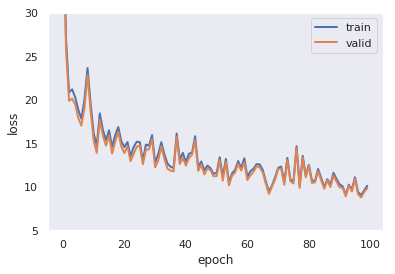

In [34]:
 def train_valid_plot(train, valid):
    plt.plot(train, linewidth=2, label="train")
    plt.plot(valid, linewidth=2, label="valid")
    plt.grid()
    plt.legend()
    plt.ylim(5, 30) 
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
    
train_valid_plot(hist['train'], hist['valid'])

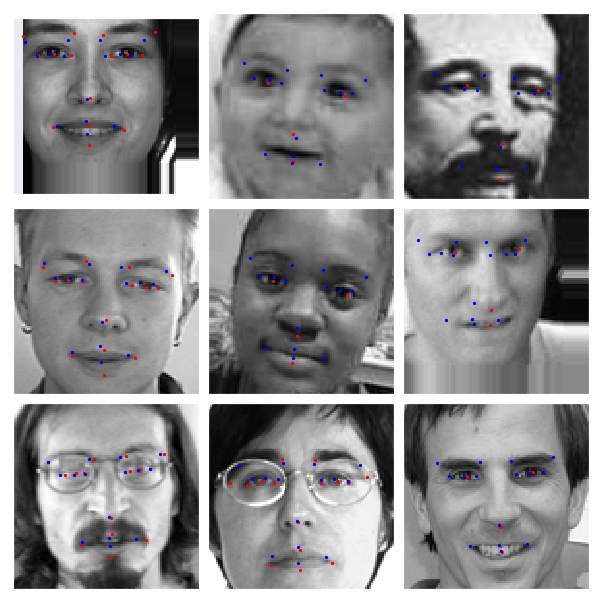

In [37]:
y_pred = Convnet_trained(torch.tensor(X_valid[:30]).float().reshape(-1,1,96,96)).detach().numpy()
plot_sample(X_valid[:30], dim=3, key=y_valid[:30], key_pred=y_pred) 

In [36]:
torch.save(Convnet_trained.state_dict(), 'full.h5')